In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2
from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
bell = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='cognac_cmap',rmax=100.)

---
## Input signal : Linear chirp signal

In [3]:
f0 = 3000.   # central frequency (Hz)
T = 1.       # signal duration (s)
B = 500.     # bandwidth (Hz)
m = B / T

SL = 185.               # source level (dB)
pref = 1.e-6            # pression de reference (Pascal)
A = pref * 10**(SL/20)  # amplitude 

###
fe = 2*(f0 + B/2.)  # fréquence d'échant. min
dt = 1/(fe*10.)

# signal definition : linear chirp 
t = np.arange(0.,60., dt)  #1.e-5 )    #fenetre de calcul    # 1.e-1/f0
t0 = 1.
s = A * np.sin (2.*np.pi * (f0 + m*(t-t0-T)/2.) * (t-t0))
s[np.where( (t<t0) | (t>T+t0))] = 0.

### Pour un dirac : 
#s = A * np.sin (2.*np.pi * (f0 + m*(t-t0-T)/2.) * (t-t0)) * 0.
#s[np.where(t==t0)]=1

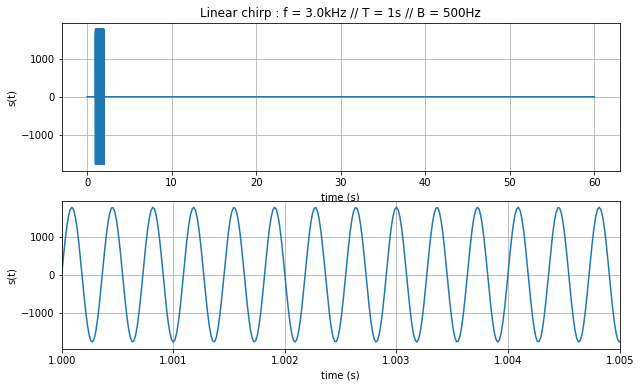

In [4]:
# plot temporal signal
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(t,s)
plt.title('Linear chirp : f = %.1fkHz // T = %ds // B = %dHz' %(f0/1000.,T,B))
plt.xlabel('time (s)')
plt.ylabel('s(t)')
plt.grid()

plt.subplot(212)
plt.plot(t,s)
plt.xlabel('time (s)')
plt.ylabel('s(t)')
plt.xlim([1.0,1.005])
plt.grid()
plt.show()

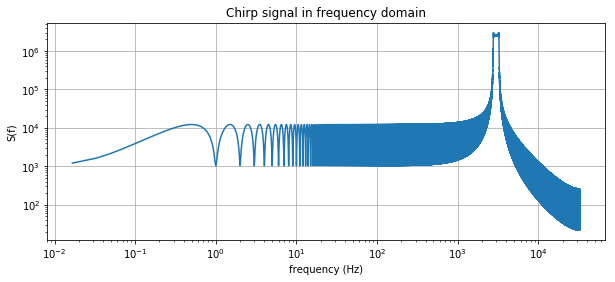

In [5]:
# Fourier transform
S = np.fft.fft(s)
freq = np.fft.fftfreq(t.shape[-1],d=t[1]-t[0])  # [0, 1/fenetre, 2/fenetre,.., Ni = 1/(2*dt), -Ni,.., -1/fenetre]
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(111)
ip = np.where(freq>0)[0]
ax.plot(freq[ip], abs(S[ip]))
ax.set_yscale('log')
ax.set_xscale('log')
plt.title ('Chirp signal in frequency domain')
plt.xlabel('frequency (Hz)')
plt.ylabel('S(f)')
ax.grid()

---
## 1 - Output signal :  Perfect signal (no loss, no multipath, no noise) 

In [6]:
# signal temporel de sortie parfait :

t_out = 15.
s_out = A * np.sin (2.*np.pi * (f0 + m*(t-t_out-T)/2.) * (t-t_out))
s_out[np.where( (t<t_out) | (t>T+t_out))] = 0.


### Pour un dirac : 
#s_out = A * np.sin (2.*np.pi * (f0 + m*(t-t_out-T)/2.) * (t-t_out)) * 0.
#s_out[np.where(t==t_out)]=1

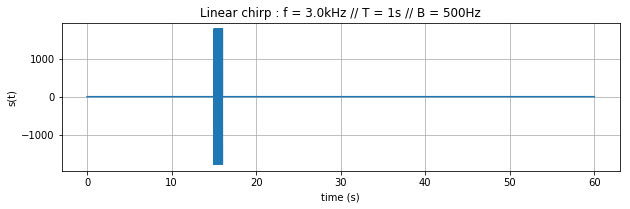

In [7]:
# plot temporal signal
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(t,s_out)
plt.title('Linear chirp : f = %.1fkHz // T = %ds // B = %dHz' %(f0/1000.,T,B))
plt.xlabel('time (s)')
plt.ylabel('s(t)')
plt.grid()

In [8]:
### Le temps d'arrivée exact du signal est 15s.

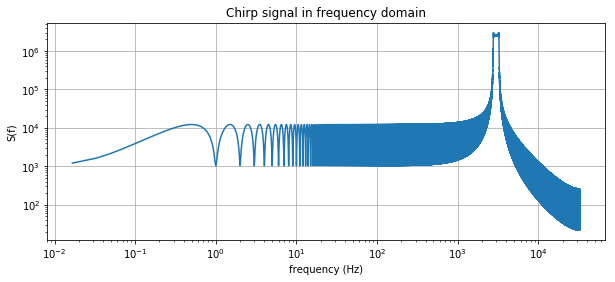

In [9]:
# Fourier transform
Sout = np.fft.fft(s_out)
#freq = np.fft.fftfreq(t.shape[-1],d=t[1]-t[0])  #[0, 1/fenetre, 2/fenetre,.., Ni = 1/(2*dt), -Ni,.., -1/fenetre]
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(111)
ip = np.where(freq>0)[0]
ax.plot(freq[ip], abs(Sout[ip]))
ax.set_yscale('log')
ax.set_xscale('log')
plt.title ('Chirp signal in frequency domain')
plt.xlabel('frequency (Hz)')
plt.ylabel('S(f)')
ax.grid()

---
### Convolution 

In [10]:
Conv = Sout*S
Ifft = np.fft.ifft(Conv)

#plt.plot(t, np.real(Ifft), 'b')
#plt.plot(t, np.imag(Ifft), 'r')

Signal = np.abs(Ifft)

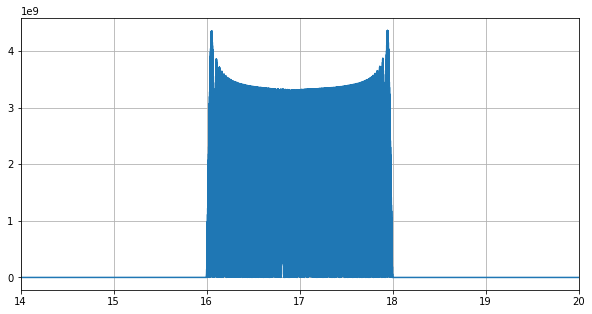

In [11]:
plt.figure(figsize=(10,5))
plt.plot(t, Signal)
plt.xlim([14.,20.])
plt.grid()

In [12]:
seuil = 1.   ## sur quels critères doit-on fixer le seuil de détection ? 
dt_final = t[np.where(Signal > seuil)][0] - 2*t0
print("Le temps de trajet calculé par convolution est de %.6fs." %dt_final )

Le temps de trajet calculé par convolution est de 14.000031s.


In [13]:
### vérité : 
print("Le temps de trajet réel est de %.6fs." %(t_out - t0))

Le temps de trajet réel est de 14.000000s.


---
---
# 2 - With multipath (no noise)

In [14]:
# sonar equation
SL = 185.                 # Souce level (dB)
NL = 82.                  # Noise level (dB)
DI = 0.                   # Directivity index (dB)
B = 200.                  # bandwidth (Hz)
T = 1.                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)   # Processing gain (dB)


In [15]:
Arr1, Pos1 = bell.read_arrivals_asc ('../files_arr/isocel_parfait.arr', Narrmx = 180)

isd, irr, ird = 0, 1, 1 
Narr = int(Arr1['Narr'][irr,ird,isd])
times = Arr1['delay'][irr, :Narr, ird, isd]
Amp_bell = Arr1['A'][irr,:Narr, ird, isd]

np.save ('times', times)
np.save ('Amp_bell', Amp_bell)

Max.number of arrivals for source index 0 is 174


In [16]:
### output signal 

#t_out = np.array([8., 8.1, 8.35, 8.5])
#Amp = np.array([1.,0.9,0.6,0.5])

times    = np.load('times.npy')
Amp_bell = np.load('Amp_bell.npy')

TL = -20*np.log10(abs(Amp_bell))
Amp = pref * 10** ((SL - TL + PG)/20.)

t_out = times
s_out = np.zeros((t_out.size, t.size))

for i in range (t_out.size) : 
    t1 = t_out[i]
    s1 =  Amp[i]* np.sin (2.*np.pi * (f0 + m*(t-t1-T)/2.) * (t-t1))
    s1[np.where( (t<t1) | (t>T+t1))] = 0.
    
    ### dirac
    #s1 = Amp[i] * np.sin (2.*np.pi * (f0 + m*(t-t1-T)/2.) * (t-t1)) *0.
    #s1[np.where(t==t1)]=Amp[i]
    
    s_out[i,:] = s1
    
S_out = np.array([sum(s_out[:,j]) for j in range(s_out.shape[1])])

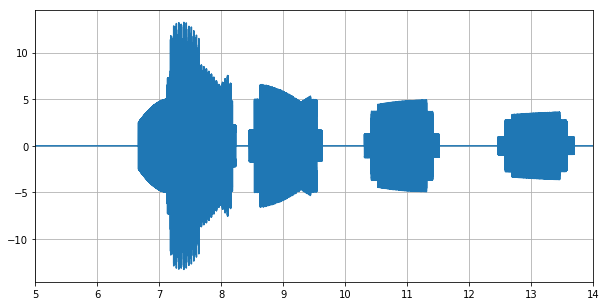

In [17]:
plt.figure(figsize=(10,5))
plt.plot(t, S_out)
plt.xlim([5.,14.])
plt.grid()

In [18]:
S_out_fft = np.fft.fft(S_out)
Convol = S*S_out_fft
Ifft = np.fft.ifft(Convol)
Signal1 = np.abs(Ifft)

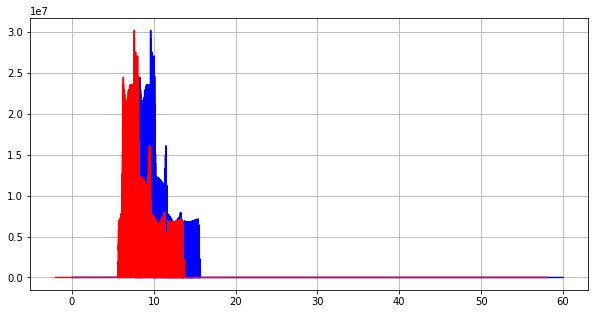

In [19]:
plt.figure(figsize=(10,5))
plt.plot(t, Signal1,'b')
plt.plot(t-2*t0, Signal1, 'r')
#plt.xlim([14.,20.])
plt.grid()

In [20]:
seuil = 0.01   ## sur quels critères doit-on fixer le seuil de détection ? 
dt_final = t[np.where(Signal1 > seuil)][0] - 2*t0
print("Le temps de trajet calculé par convolution est de %.6fs." %dt_final )

Le temps de trajet calculé par convolution est de 5.666692s.


In [21]:
### vérité : 
sort = sorted(times)
print("Le temps de trajet réel est de %.6fs." %(sort[0] - t0))

Le temps de trajet réel est de 5.666667s.


---
---
---
# 3 - Noise added 

In [22]:
### bruit gaussien 
NL = 82. 
amp_noise = pref * 10**(NL/20.)
noise = np.random.randn(t.size)*amp_noise # bruit Gaussien, moyenne=0, variance=noise level..

In [23]:
S_noise = S_out + noise

In [24]:
amp_noise

0.012589254117941661

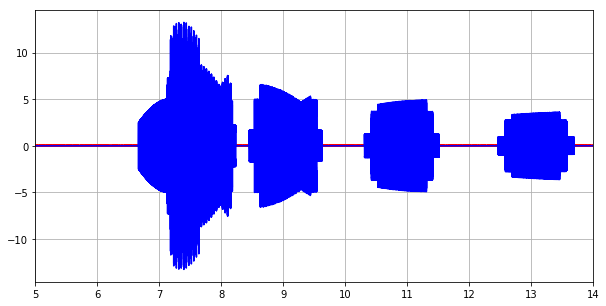

In [25]:
plt.figure(figsize=(10,5))
plt.plot(t,noise,'r')
plt.plot(t, S_out, 'b')
plt.xlim([5.,14.])
plt.grid()

In [26]:
S_noise_fft = np.fft.fft(S_noise)
Convol = S*S_noise_fft
Ifft = np.fft.ifft(Convol)
Signal2 = np.abs(Ifft)

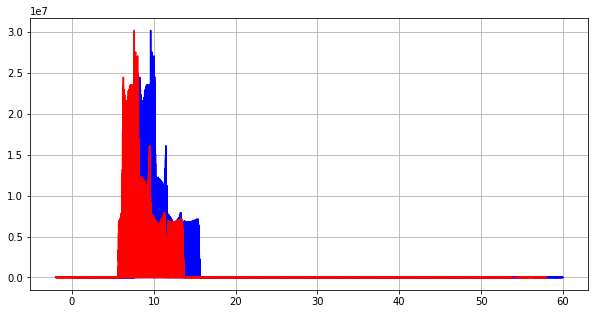

In [35]:
plt.figure(figsize=(10,5))
plt.plot(t, Signal2,'b')
plt.plot(t-2*t0, Signal2, 'r')
#plt.ylim(ymin = 0., ymax = 0.2e5)
plt.grid()

In [37]:
#RL = SL - np.max(TL) - NL + DI + PG 
#seuil_dB = NL + 10.
#seuil =  pref * 10**(seuil_dB/20.)

seuil = 1.e5   ## sur quels critères doit-on fixer le seuil de détection ? 

dt_final = t[np.where(Signal2 > seuil)][0] - 2*t0
print("Le temps de trajet calculé par convolution est de %.6fs." %dt_final )

Le temps de trajet calculé par convolution est de 5.667385s.


In [38]:
### vérité : 
sort = sorted(times)
print("Le temps de trajet réel est de %.6fs." %(sort[0] - t0))

Le temps de trajet réel est de 5.666667s.


---
---
### Question en suspens : Le seuil de détection  : Comment le fixer ? Sur quels critères ? 
---
---

# Code résumé

In [125]:
f0 = 3000.   # central frequency (Hz)
T = 1.       # signal duration (s)
B = 500.     # bandwidth (Hz)
m = B / T


### EMITTED SIGNAL (linear chirp)

SL = 185.               # source level (dB)
pref = 1.e-6            # pression de reference (Pascal)
A = pref * 10**(SL/20)  # amplitude 
###
fe = 2*(f0 + B/2.)  # fréquence d'échant. min
dt = 1/(fe*10.)
###
t = np.arange(0.,60., dt)  #1.e-5 )    #fenetre de calcul    # 1.e-1/f0
t0 = 1.
s = A * np.sin (2.*np.pi * (f0 + m*(t-t0-T)/2.) * (t-t0))
s[np.where( (t<t0) | (t>T+t0))] = 0.

S = np.fft.fft(s)


### RECEIVED SIGNAL (with losses, multipath and noise)

times    = np.load('times.npy')     #from bellhop
Amp_bell = np.load('Amp_bell.npy')
TL = -20*np.log10(abs(Amp_bell))
Amp = pref * 10** ((SL - TL + PG)/20.)

t_out = times
s_out = np.zeros((t_out.size, t.size))

for i in range (t_out.size) : 
    t1 = t_out[i]
    s1 =  Amp[i]* np.sin (2.*np.pi * (f0 + m*(t-t1-T)/2.) * (t-t1))
    s1[np.where( (t<t1) | (t>T+t1))] = 0.
    s_out[i,:] = s1
    
S_out = np.array([sum(s_out[:,j]) for j in range(s_out.shape[1])])

## add noise
NL = 82. 
amp_noise = pref * 10**(NL/20.)
noise = np.random.randn(t.size)*amp_noise # bruit Gaussien, moyenne=0, variance=noise level..
S_noise = S_out + noise

S_noise_fft = np.fft.fft(S_noise)



### CONVOLUTION
Convol = S*S_noise_fft
Ifft = np.fft.ifft(Convol)
Signal = np.abs(Ifft)


### TRESHOLD 
seuil = 1.e5   ## sur quels critères doit-on fixer le seuil de détection ? 
dt_final = t[np.where(Signal > seuil)][0] - 2*t0
print("Le temps de trajet calculé par convolution est de %.6fs." %dt_final )

### TRUTH (pour vérifier les calculs) 
sort = sorted(times)
print("   (temps de trajet réel : %.6fs.)" %(sort[0] - t0))

Le temps de trajet calculé par convolution est de 5.667369s.
   (temps de trajet réel : 5.666667s.)


---
---
---
# ANNEXES 

---
### Vérification du bon fonctionnement avec la méthode fftconvolve de scipy

In [ ]:
### test avec diracs
Sortie = fftconvolve(s,s_out,mode='full')
plt.plot(np.arange(0.,Sortie.size)*dt,Sortie)
plt.xlim([14.,20.])
plt.grid()

----
### Quel offset pour la sortie de la convolution ? 

In [ ]:
## formule trouvée : dt_final = sortie - 2*t0
## exemples avec des diracs 

t = np.arange(0.,60., dt) 
t0 = 13.
s = A * np.sin (2.*np.pi * (f0 + m*(t-t0-T)/2.) * (t-t0)) * 0.
s[np.where(t==t0)]=1.

t_out = 15.
s_out = A * np.sin (2.*np.pi * (f0 + m*(t-t_out-T)/2.) * (t-t_out)) * 0.
s_out[np.where(t==t_out)]=1.

S = np.fft.fft(s)
Sout = np.fft.fft(s_out)

Conv = Sout*S
Ifft = np.fft.ifft(Conv)
Signal = np.abs(Ifft)

tt = t[np.where(Signal==np.max(Signal))][0]
print('Sortie brute de la convolution : %.1f' %tt)

dt_final = t[np.where(Signal==np.max(Signal))][0] - 2*t0
print('temps de trajet calculé par convolution : %.6fs.' %dt_final)